# Clustering
We handle clustering ploblem as an optimization problem.

## What you will learn
1. Clustering by annealing
2. Clustering by QAOA

## Install Blueqat

In [1]:
!pip install blueqat

You should consider upgrading via the 'pip install --upgrade pip' command.


## Overview
Clustering is the classification of a large number of data with different values into a number of clusters.  
By classifying data with similar characteristics into the same cluster, it is possible to group them, which is used for marketing and other purposes.

## Example

### Clustering by annealing
Consider the case where four points (nodes) are divided into two clusters.  

First we have a pair of qubits set $q_0,q_1,q_2,q_3$ and $q_4,q_5,q_6,q_7$ that represent two clusters.  
$q_0$ and $q_4$, $q_1$ and $q_5$, $q_2$ and $q_6$, $q_3$ and $q_7$ each represent the same node, and the qubit representing the cluster to which the node belongs will have the value 1, while the qubit representing the cluster to which it does not belong will have the value 0. 
For example, if node 0 belongs to cluster 1, then $q_0 = 1, q_4 = 0$, and if node 0 belongs to cluster 2, then $q_0 = 0, q_4 = 1$.  
Therefore, the required number of qubits is $4\times2=8$.

Set the cost function so that the sum of the distances between the nodes in same cluster become small.

$$
Cost = \sum d_{ij} q_i q_j\ \ \ \ (q_i \in \{0, 1\})
$$

$d_{ij}$ is the distance between nodes $i$ and $j$.

The constraint is set so that only one of the qubits representing the same node will be 1 and the rest will be 0.
$$
Constraint = \sum(\sum_{i}^n q_i - 1)^2
$$

The following is an implementation by blueqat.

In [28]:
import numpy as np
import pandas as pd
import networkx as nx
from blueqat.wq import *
import matplotlib.pyplot as plt
%matplotlib inline

First, we create the data. This time, we will divide the 4 nodes into 2 clusters.

In [4]:
n_node = 4
n_cluster = 2
N = n_node*n_cluster

print('nodes',n_node)
print('clusters',n_cluster)
print('qubits',N)

nodes 4
clusters 2
qubits 8


Prepare the data with the coordinates set by random numbers.  
This time, we will generate four data points with two-dimensional coordinates $(x, y)$.

In [9]:
x,y = [],[]

for i in range(n_cluster):
    x = np.append(x, np.random.normal(np.random.randint(0,n_cluster*10), 1.5, int(n_node/n_cluster)))
    y = np.append(y, np.random.normal(np.random.randint(0,n_cluster*10), 1.5, int(n_node/n_cluster)))

df = pd.DataFrame({'x':x,'y':y})
df

,x,y
0,1.599536,6.559048
1,1.300268,4.159955
2,12.977924,-0.555037
3,14.496250,2.928867


Check the distribution of the generated data points.

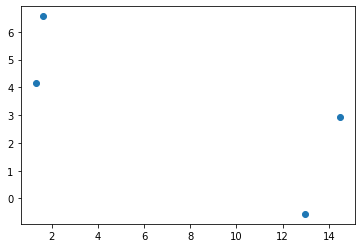

In [10]:
#plot
plt.scatter(df['x'], df['y'])

Next, we will create a QUBO matrix.

First, we prepare a QUBO matrix that represents a cost function based on the distance between nodes.

In [11]:
def initCost(data, n_cluster):
    # prepare matrix which represents destances of nodes
    n_node = len(data)
    d = np.zeros((n_node, n_node))

    # Find the distance from the X and Y coordinates of the data.
    for i in range(0, n_node-1):
        for j in range(i+1, n_node):
            a = np.array([data['x'][i], data['y'][i]])
            b = np.array([data['x'][j], data['y'][j]])
            d[i][j] = np.linalg.norm(a-b)

    # The size of the QUBO matrix is (the number of qubits, the number of qubits).
    N = n_node*n_cluster
    A = np.zeros((N, N))

    # Duplicate and insert as many distances matrix as there are clusters.
    for i in range(0, n_node-1):
        for j in range(i+1, n_node):
            for k in range(n_cluster):
                A[i+k*n_node][j+k*n_node] = d[i][j]
    
    return A, d

In [12]:
A,d = initCost(df, n_cluster)
A

array([[ 0.        ,  2.41768667, 13.41931173, 13.39788903,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 12.59360145, 13.25328239,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  3.80038179,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         2.41768667, 13.41931173, 13.39788903],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 12.59360145, 13.25328239],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  3.80038179],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

Next, we prepare a QUBO matrix representing the constraints.  
This time, we will set constraints between $q_0$ and $q_4$, $q_1$ and $q_5$, $q_2$ and $q_6$, and $q_3$ and $q_7$, respectively.  
Since each node belongs to only one of the clusters, we set the constraint term such that it is minimized when one of the each is 1 and the another is 0, as follows

$$
(q_0+q_4 - 1)^2 = -q_0-q_4+2q_0q_4 + 1\\
(q_1+q_5 - 1)^2 = -q_1-q_5+2q_1q_5 + 1\\
(q_2+q_6 - 1)^2 = -q_2-q_6+2q_2q_6 + 1\\
(q_3+q_7 - 1)^2 = -q_3-q_7+2q_3q_7 + 1\\
$$

The constant term on the right side can be ignored.

In [13]:
B = np.diag([-1]*N)

for i in range(n_node):
    B[i][i+n_node] = 2
B

array([[-1,  0,  0,  0,  2,  0,  0,  0],
       [ 0, -1,  0,  0,  0,  2,  0,  0],
       [ 0,  0, -1,  0,  0,  0,  2,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  2],
       [ 0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1]])

Finally, add the two QUBO matrices together.  
Here, the hyperparameter $M$, which represents the strength of the constraint, is applied to the constraint QUBO as a weight. 

If $M$ is too small, there is a high possibility of getting a solution that does not satisfy the constraints.  
On the other hand, if $M$ is too large, the constraint is easily satisfied, but the minimization of the cost function is difficult, and the possibility of obtaining the optimal solution is low.

Let's also check the network diagram of the QUBO matrix we have created.  
Each point on the network diagram represents a qubit $q_i$, and the edges connecting the points mean that there is an interaction between $q_i$ and $q_j$.

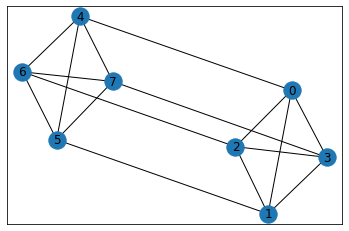

In [14]:
# prepare QUBO
M = 1
qubo = A+B*M

# Check network diagram
G = nx.from_numpy_matrix(qubo)
nx.draw_networkx(G)
plt.show()

Set the value of $M$ again, and find the optimal solution by annealing.

In [15]:
M = 10
qubo = A+B*M

a = Opt()
a.qubo = qubo
res = a.run()

res

[0, 0, 1, 1, 1, 1, 0, 0]

Let's check the calculation results.  
The result obtained shows the optimal solution for $[q_0, q_1, ... , q_7]$.  
To check the cluster classification, it is enough to look at the first half, $q_0$ to $q_3$.  
Let's color　code the points according to the cluster they belong to.

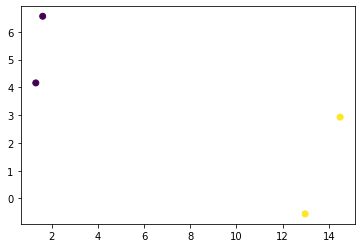

In [16]:
df['cluster'] = res[:4]
plt.scatter(df['x'], df['y'], c=df['cluster'])

You can see that points that are close to each other are classified into the same cluster.

### Clustering by QAOA

Next, I will try to solve it by QAOA.

In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import blueqat
from blueqat import Circuit
from blueqat import vqe,opt
from blueqat.pauli import X,Y,Z

%matplotlib inline

Creating a QUBO is the same as annealing.  
However, in QAOA, in this case, the constraint term can be removed by implementing the XY mixer circuit.

The $XY$ mixer performs a time evolution by the following matrix $H_{XY}$.  

$$
H_{XY} = (X_0 X_1 + Y_0 Y_1)/2 = \begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
$$

The time evolution is represented by the following two-qubit gate $U_{XY}$.

$$
U_{XY} = e^{-i\theta H_{XY}} = \begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & \cos\theta & -i\sin\theta & 0 \\
0 & -i\sin\theta & \cos\theta & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
$$

The amplitude is exchanged between the two states $\lvert 01\rangle$ and $\lvert 10\rangle$.   
Therefore, if we prepare a superposition of $\lvert 01\rangle$ and $\lvert 10\rangle$ as initial states and apply $U_{XY}$, we can search only between the two states of $\lvert 01\rangle$ and $\lvert 10\rangle$ while keeping the amplitudes of $\lvert 00\rangle$ and $\lvert 11\rangle$, which do not satisfy the constraint conditions, at zero.   
This means that constraints can be removed from QUBO because solutions that do not satisfy the constraints will not be explored.

Thus, the QUBO matrix consists only of the cost function.  
Expressed in a network diagram, we can see that there are fewer edges than when the constraint term was included.  
This means that the problem becomes simpler with fewer interactions.

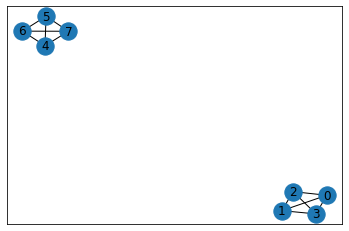

In [17]:
# prepare QUBO
qubo = A

# Check network diagram
G = nx.from_numpy_matrix(qubo)
nx.draw_networkx(G)
plt.show()

Implement the initial state and $XY$ mixer circuit to satisfy the constraints and execute optimization.  

In [31]:
from blueqat import Circuit, vqe
from blueqat.pauli import X, Y, X

q = pauli(qubo)
step = 2

#mixer and init state
for i in range(n_node):
    if i==0:
        mixer = 0.5*X[0]*X[n_node] + 0.5*Y[0]*Y[n_node]
        init = Circuit().h[0].cx[0,n_node].x[0]
    else:
        mixer += 0.5*X[i]*X[i+n_node] + 0.5*Y[i]*Y[i+n_node]
        init.h[i].cx[i,i+n_node].x[i]

print(mixer)
print(init)

result = vqe.Vqe(vqe.QaoaAnsatz(q, step, init, mixer)).run()
res_qaoa = result.most_common(1)[0][0]
res_qaoa

0.5*X[0]*X[4] + 0.5*Y[0]*Y[4] + 0.5*X[1]*X[5] + 0.5*Y[1]*Y[5] + 0.5*X[2]*X[6] + 0.5*Y[2]*Y[6] + 0.5*X[3]*X[7] + 0.5*Y[3]*Y[7]
Circuit(8).h[0].cx[0, 4].x[0].h[1].cx[1, 5].x[1].h[2].cx[2, 6].x[2].h[3].cx[3, 7].x[3]


(1, 1, 0, 0, 0, 0, 1, 1)

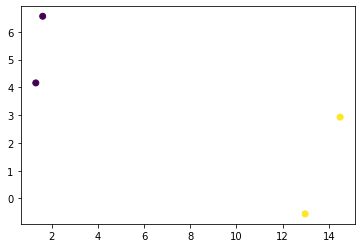

In [32]:
resc = []

for i in range(N):
    if res_qaoa[i] == 1:
        resc.append(int(i/n_node))

df['cluster_qaoa'] = resc

plt.scatter(df['x'], df['y'], c=df['cluster_qaoa'])

As in the case of using annealing, we can see that close points are classified into the same cluster.

From the above, we were able to perform clustering using annealing and QAOA respectively.